# Image Compression Methods Analysis 
by: 
 - Markiian Mandzak
 - Denys Botuk
 - Yurii Voievidka

In [1]:
import numpy as np
from matplotlib.image import imread
import pywt
import matplotlib.pyplot as plt
import cv2
import itertools
import os
import pandas as pd
import time
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from time import perf_counter
from scipy.fftpack import dctn, idctn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Loading Datasets Path

In [2]:
# Loading ALL images, really all
file_paths = []  
for root, dirs, files in os.walk("./data"):
    for file in files:
        if file != '.DS_Store':
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

In [45]:
test_image_path = './data/other/lenna.png'
original_gray_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

In [46]:
factors_to_show = [4, 64, 256]
keeps = np.concatenate([np.linspace(0.0009, 0.9999, 500), 1. / np.array(factors_to_show)])
keeps.sort()

# Metrics for Comparison

In [47]:
def average_time(method, *args, iters_number=10):
    times = []
    for i in range(iters_number):
        time_start = perf_counter()
        method(*args)
        time_stop = perf_counter()
        times.append(time_stop - time_start)
    return np.mean(times)

In [48]:
def compression_factor(size_original, size_compressed):
    return size_original / size_compressed

# Discrete Fourier Transform

In [49]:
def fourier_compress_image(original_image, keep):
    coeffs = np.fft.fft2(original_image)
    Csort = np.sort(np.abs(coeffs.reshape(-1)))

    thresh = Csort[int(np.floor((1 - keep) * len(Csort)))]
    ind = np.abs(coeffs) > thresh
    Cfiltered = coeffs * ind

    return Cfiltered

def fourier_reconstruct_image(coeffs):
    return np.fft.ifft2(coeffs)

def fourier_statistics(original_image, keep):
    Cfiltered = fourier_compress_image(original_image, keep)

    compr_time = average_time(fourier_compress_image, original_image, keep)
    compr_factor = compression_factor(Cfiltered.size, np.sum(np.abs(Cfiltered) > 0))

    reconstructed_image = fourier_reconstruct_image(Cfiltered)

    psnr_ = psnr(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())
    ssim_ = ssim(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())

    return reconstructed_image, compr_time, compr_factor, psnr_, ssim_

In [50]:
fourier_compressed_images = list()
fourier_compression_times = list()
fourier_compression_factors = list()
fourier_psnrs = list()
fourier_ssims = list()

for keep in keeps:
    fourier_compr_image, fourier_compr_time, fourier_compr_factor, fourier_psnr, fourier_ssim = dct_statistics(original_gray_image, keep)

    fourier_compressed_images.append(fourier_compr_image)
    fourier_compression_times.append(fourier_compr_time)
    fourier_compression_factors.append(fourier_compr_factor)
    fourier_psnrs.append(fourier_psnr)
    fourier_ssims.append(fourier_ssim)

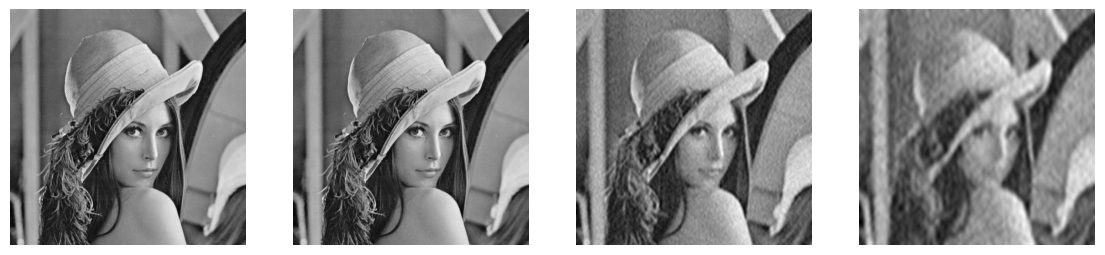

In [51]:
plt.figure(figsize=(14, 8))

plt.subplot(1, len(factors_to_show) + 1, 1)
plt.imshow(original_gray_image, cmap='gray')
plt.axis('off')

for j, factor in enumerate(factors_to_show, start=1):
    index = np.argmin(np.abs(np.array(fourier_compression_factors) - factor))
    plt.subplot(1, len(factors_to_show) + 1, j + 1)
    plt.imshow(fourier_compressed_images[index], cmap='gray')
    plt.axis('off')

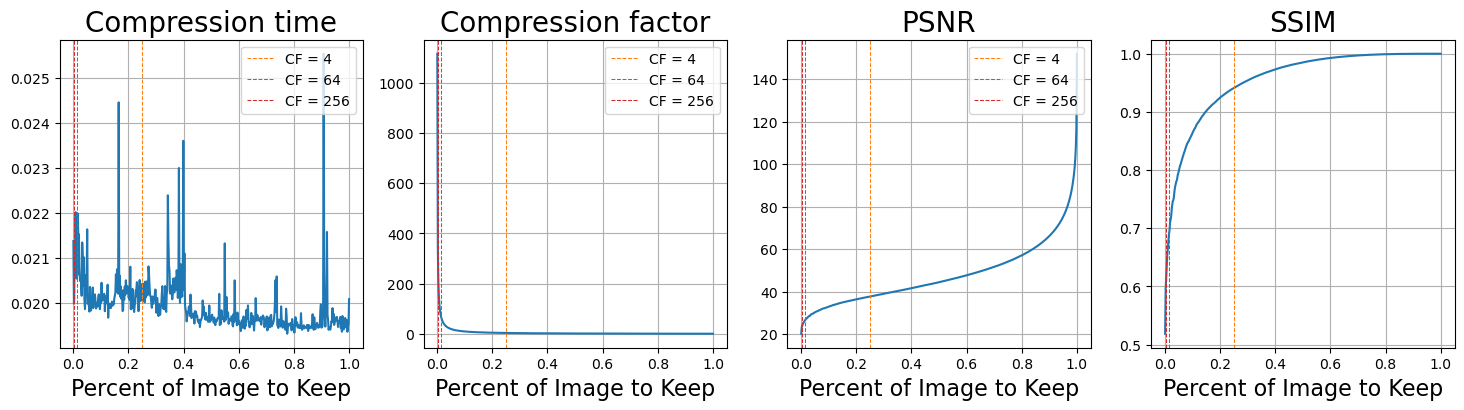

In [52]:
indexes = [np.argmin(np.abs(np.array(fourier_compression_factors) - factor)) for factor in factors_to_show]

plt.figure(figsize=(18, 4))

ax = plt.subplot(1, 4, 1)
plt.plot(keeps, fourier_compression_times)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(fourier_compression_factors[index])}')
plt.title(f'Compression time', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 2)
plt.plot(keeps, fourier_compression_factors)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(fourier_compression_factors[index])}')
plt.title(f'Compression factor', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 3)
plt.plot(keeps, fourier_psnrs)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(fourier_compression_factors[index])}')
plt.title(f'PSNR', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 4)
plt.plot(keeps, fourier_ssims)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(fourier_compression_factors[index])}')
plt.title(f'SSIM', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.grid(True)

# Discrete Cosine Transform

In [53]:
def dct_compress_image_with_thresh(original_image, keep):
    coeffs = dctn(original_image, norm='ortho')
    Csort = np.sort(np.abs(coeffs.reshape(-1)))

    thresh = Csort[int(np.floor((1 - keep) * len(Csort)))]
    ind = np.abs(coeffs) > thresh
    Cfiltered = coeffs * ind

    return Cfiltered

def dct_reconstruct_image(coeffs):
    return idctn(coeffs, norm='ortho')

def dct_statistics(original_image, keep):
    Cfiltered = dct_compress_image_with_thresh(original_image, keep)

    compr_time = average_time(dct_compress_image_with_thresh, original_image, keep)
    compr_factor = compression_factor(Cfiltered.size, np.sum(np.abs(Cfiltered) > 0))

    reconstructed_image = dct_reconstruct_image(Cfiltered)

    psnr_ = psnr(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())
    ssim_ = ssim(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())

    return reconstructed_image, compr_time, compr_factor, psnr_, ssim_

In [54]:
dct_compressed_images = list()
dct_compression_times = list()
dct_compression_factors = list()
dct_psnrs = list()
dct_ssims = list()

for keep in keeps:
    dct_compr_image, dct_compr_time, dct_compr_factor, dct_psnr, dct_ssim = dct_statistics(original_gray_image, keep)

    dct_compressed_images.append(dct_compr_image)
    dct_compression_times.append(dct_compr_time)
    dct_compression_factors.append(dct_compr_factor)
    dct_psnrs.append(dct_psnr)
    dct_ssims.append(dct_ssim)

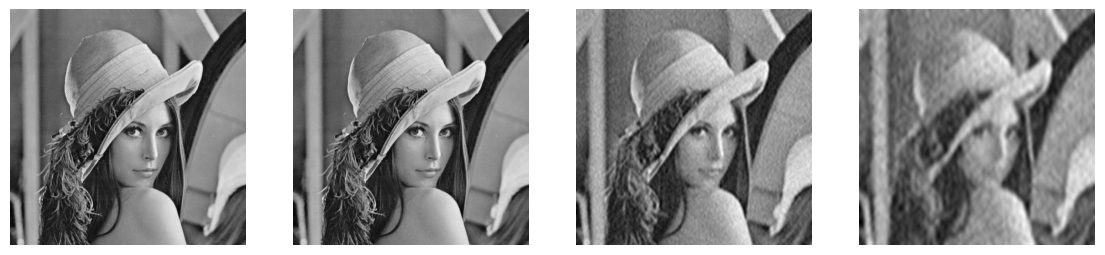

In [55]:
plt.figure(figsize=(14, 8))

plt.subplot(1, len(factors_to_show) + 1, 1)
plt.imshow(original_gray_image, cmap='gray')
plt.axis('off')

for j, factor in enumerate(factors_to_show, start=1):
    index = np.argmin(np.abs(np.array(dct_compression_factors) - factor))
    plt.subplot(1, len(factors_to_show) + 1, j + 1)
    plt.imshow(dct_compressed_images[index], cmap='gray')
    plt.axis('off')

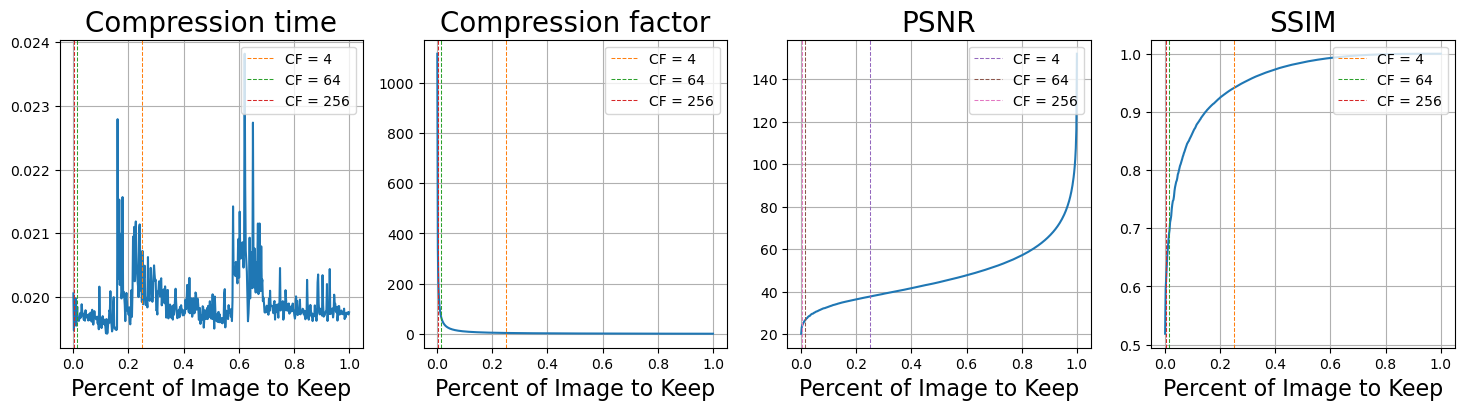

In [56]:
indexes = [np.argmin(np.abs(np.array(dct_compression_factors) - factor)) for factor in factors_to_show]

plt.figure(figsize=(18, 4))

ax = plt.subplot(1, 4, 1)
plt.plot(keeps, dct_compression_times)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(dct_compression_factors[index])}')
plt.title(f'Compression time', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 2)
plt.plot(keeps, dct_compression_factors)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(dct_compression_factors[index])}')
plt.title(f'Compression factor', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(keeps, dct_psnrs)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(dct_compression_factors[index])}')
plt.title(f'PSNR', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

ax = plt.subplot(1, 4, 4)
plt.plot(keeps, dct_ssims)
for index in indexes:
    plt.axvline(keeps[index], color=next(ax._get_lines.prop_cycler)['color'], linestyle='dashed', linewidth=0.75, label=f'CF = {int(dct_compression_factors[index])}')
plt.title(f'SSIM', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.legend(loc='upper right')
plt.grid(True)

# Quantization

In [ ]:
# Quantization

# Discrete Wavelet Transform

In this section we are going to check out how to сompress images using DWT. The main magic is hiding behind pywt.wavedec2 function that applies 2 dimentional wavelet decomposition to our image. This function applies $n+1$ low level and $n+1$ high level pass fiters where $n$ - is the level of decomposiotion. The more the level is the more is decomposition and, thus, compression.

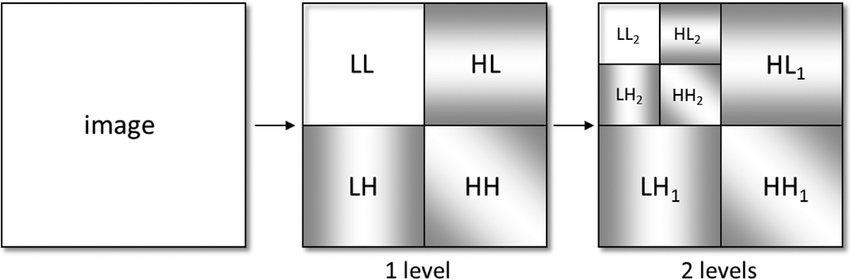

To compress image we will keep only LL block and thus can clearly see that compression factor for level 1 is 4, for level 2 is 16, for level 3 - 64 and so on

Firstly we will take test image and denormalize it as metrics ssim, and psnr requires no be image in scale from 0 to 255

In [ ]:
def normalize_and_greyscale_imge(image):
    return np.mean(image*255,-1)

# We read the test image to compare with it
test_image = normalize_and_greyscale_imge(imread(test_image_path))

In [3]:
def compress_dwt(image_path, wavelet='haar', level=2):

    # firstly we transform image to grayscale to there would be 1 channel for all images to compare
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # taking the corefficient for choosen wavelet according to level of decomposition
    coeffs = pywt.wavedec2(img, wavelet, mode="antireflect",  level=level)  

    # to compress image we will throw away coefficients that contains high frequecy components, cruel world
    coeffs_thresh = []
    coeffs_thresh.append(coeffs[0])
    for detail_coeffs in coeffs[1:]: 
        h, v, d = detail_coeffs
        h_thresh = pywt.threshold(h, np.inf, mode='hard')
        v_thresh = pywt.threshold(v, np.inf, mode='hard')
        d_thresh = pywt.threshold(d, np.inf, mode='hard')
        coeffs_thresh.append((h_thresh, v_thresh, d_thresh))
    
    # reconstruction our image with only low frequency components
    reconstructed_img = pywt.waverec2(coeffs_thresh, wavelet)
    
    compression_factor = 4**level

    return reconstructed_img, compression_factor


### Defining hyperparameters

In [4]:
maximum_level = 6
# using most common wavelets 
wavelets = ["haar" ,"sym2", "bior2.2", "db10", "coif5"]
keep = 0.99  # we will keep 70% of data

This is examples of wavelets that we are going to test

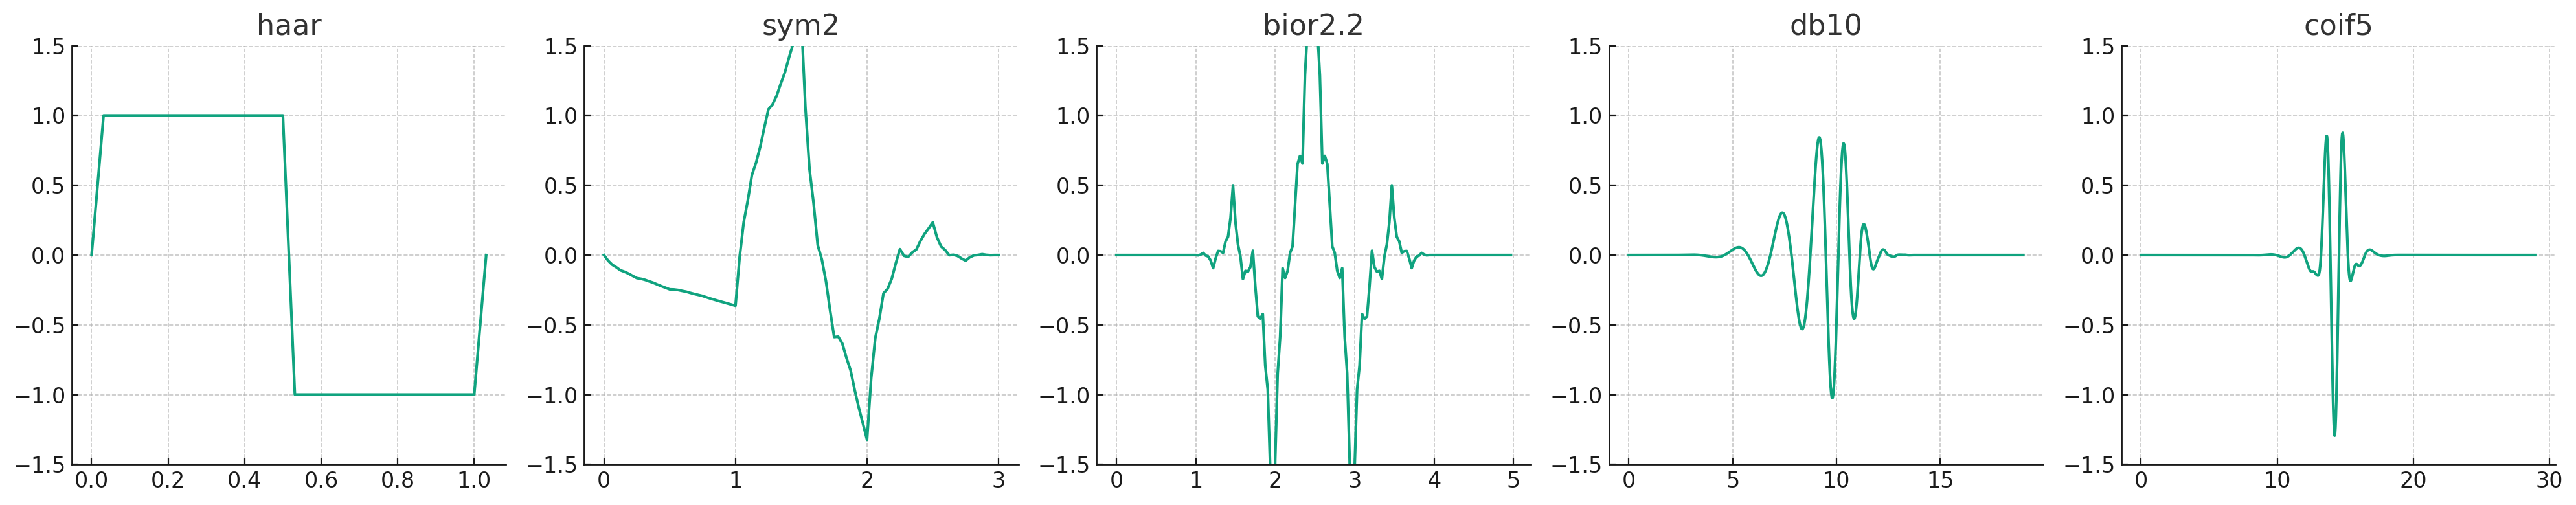

### Defining plotting settings

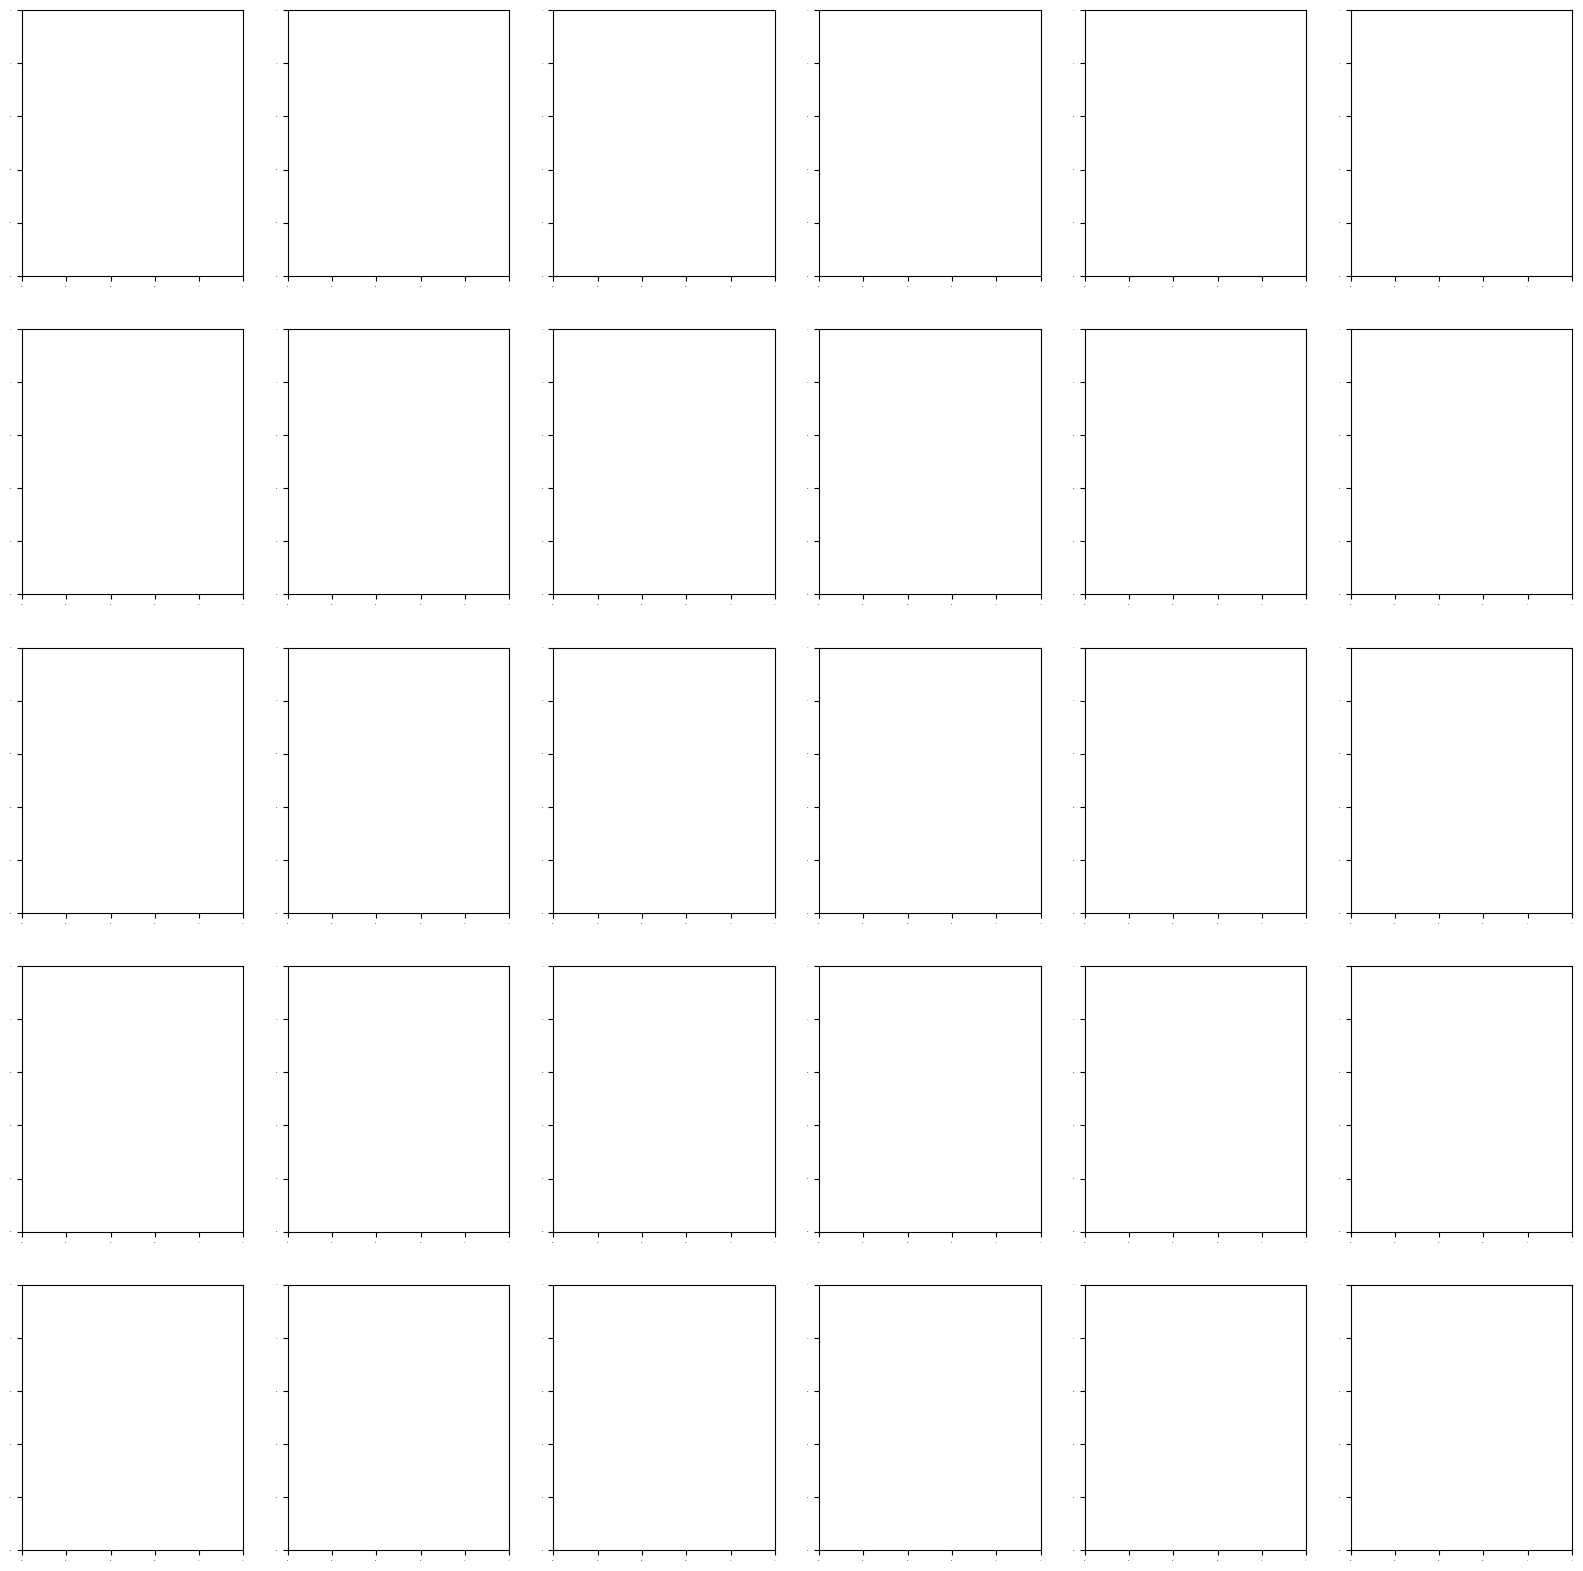

In [6]:
fig, axs = plt.subplots(len(wavelets), maximum_level, figsize=(20, 20))
psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}

plt.ioff()
# remove ticks from plot
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=1)
    ax.tick_params(axis='both', which='minor', labelsize=1)  

Here we can see comparison of wavelets

In [ ]:
for level in range(maximum_level):
    for wave_index, wave in enumerate(wavelets):
        reconstructed_image, compression_rate = compress_dwt(test_image_path, wavelet=wave, level=level)

        psnr_metric = psnr(test_image, reconstructed_image, data_range=test_image.max() - reconstructed_image.min())
        ssim_metric = ssim(test_image, reconstructed_image, data_range=test_image.max() - reconstructed_image.min())
        axs[wave_index, level].imshow(reconstructed_image, cmap='gray')
        axs[wave_index, level].set_title(f'Level {level}, PSNR: {np.round(psnr_metric, 2)}, CR: {compression_rate}', fontsize=10)

        if level == 0:  
            axs[wave_index, level].set_ylabel(wave, rotation=0, size='large', labelpad=30, verticalalignment='center')

        psnr_values[wave].append(psnr_metric)
        compressions[wave].append(compression_rate)
        ssims[wave].append(ssim_metric)

plt.tight_layout()
plt.show()

## Gathering data by testing on all datasets

In [7]:
psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}
times = {wavelet: [] for wavelet in wavelets}

As we have plenty of datasets this code section will take some time. We will take every metric with every image and wavelet decsribed in paper and will take the means accross all images to see how DWT performs in general

In [ ]:
for level in range(maximum_level):
    local_psnr_values = []
    local_compressions = []
    local_ssims = []
    local_times = []
    for wave_index, wave in enumerate(wavelets):
        for index, image_path in enumerate(file_paths):
            if not (index % 10):
                base_image =  np.mean(imread(image_path)*255, -1)
                start_time = time.perf_counter()
                reconstructed_image, compression_rate = compress_dwt(image_path, wavelet=wave, level=level)
                end_time = time.perf_counter()
                if reconstructed_image.shape[0] == base_image.shape[0] and reconstructed_image.shape[1] == base_image.shape[1]:
                    psnr_metric = psnr(base_image, reconstructed_image, data_range=base_image.max() - reconstructed_image.min())
                    ssim_metric = ssim(base_image, reconstructed_image, data_range=base_image.max() - reconstructed_image.min())

                local_times.append(end_time - start_time)
                local_psnr_values.append(psnr_metric)
                local_compressions.append(compression_rate)
                local_ssims.append(ssim_metric)
        
        times[wave].append(np.mean(local_times))
        psnr_values[wave].append(np.mean(local_psnr_values))
        compressions[wave].append(np.mean(local_compressions))
        ssims[wave].append(np.mean(local_ssims))

### Let's plot the metrics that we have gathered

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
marker = itertools.cycle((',', '+', '.', 'o', '*')) 


# Compression time
for wavelet in wavelets:
    axs[0].plot(np.arange(1, maximum_level+1), times[wavelet],label=wavelet, marker=next(marker))
    axs[0].set_title('Compression time')
    axs[0].grid('on')
    axs[0].set_xlabel('Level')
    axs[0].set_ylabel('PSNR (dB)')
    axs[0].set_xlabel('Level')
    axs[0].set_ylabel('time (seconds)')

# Compression factor
for wavelet in wavelets:
    axs[1].plot(np.arange(1, maximum_level+1),  compressions[wavelet],label=wavelet, marker=next(marker))
    axs[1].set_title('Compression factor')
    axs[1].grid('on')
    axs[1].set_xlabel('Level')
    axs[1].set_ylabel('Times')

# PSNR
for wavelet in wavelets:
    axs[2].plot(np.arange(1, maximum_level+1), psnr_values[wavelet], label=wavelet, marker=next(marker))
    axs[2].set_title('PSNR')
    axs[2].grid('on')
    axs[2].set_xlabel('Level')
    axs[2].set_ylabel('PSNR (dB)')

# SSIM
for wavelet in wavelets:
    axs[3].plot(np.arange(1, maximum_level+1),  ssims[wavelet], label=wavelet, marker=next(marker))
    axs[3].set_title('SSIM')
    axs[3].grid('on')
    axs[3].set_xlabel('Level')
    axs[3].set_ylabel('SSIM (%)')
    handles, labels = axs[3].get_legend_handles_labels()


fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, -0.001), ncol=len(wavelets))
plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

### Results

We can see that Haar wavelet compresse the images quicker than any other wavelet but it has the biggest image corruption according to SSIM plot. We also see that Daubechies10 wavelet preserves the most of image quality and comresses the image faster compared to Coilfel5. That is one of the reasons why Daubechies wavelet family is used in practice to compress the images